In [57]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import desc

In [58]:
import numpy as np
import pandas as pd

In [59]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [60]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [61]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [62]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [63]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [64]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [65]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

C:\Users\e_enr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


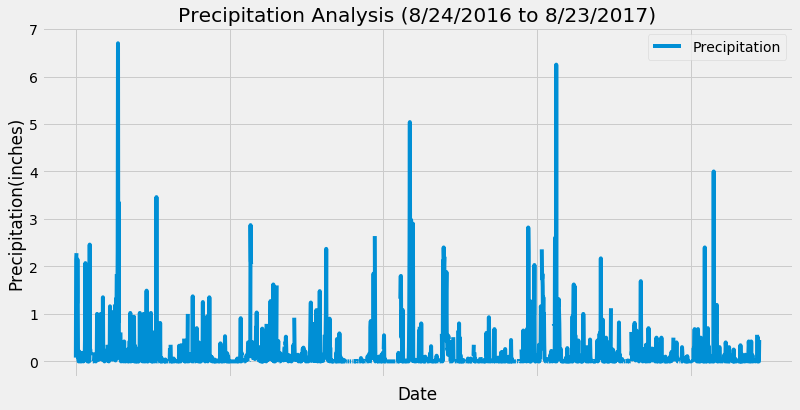

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Query the database via to determine last data point
last_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_data
first_data = dt.date(2017, 8, 23) - dt.timedelta(days=365)
first_data
# Perform a query to retrieve the data and precipitation scores
annualprcp = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_data).\
                        order_by(Measurement.date).all()
annualprcp
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(annualprcp, columns=['Date', 'Prcp'])
prcp_df.set_index(prcp_df['Date'], inplace=True)
prcp_df.head()
# Sort the dataframe by date
sorted_prcp_df = prcp_df.sort_values('Date')
sorted_prcp_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
sorted_prcp_df.plot('Date', 'Prcp',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

![precipitation](Images/precipitation.png)

In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [68]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [70]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = [Measurement.station, 
       func.count(Measurement.station)]
activestations_query = session.query(*active_stations).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
activestations_query


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [71]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps_USC281 = engine.execute('SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = "USC00519281"').fetchall()
USC281_stats = temps_USC281[0]
USC281_stats


(54.0, 85.0, 71.66378066378067)

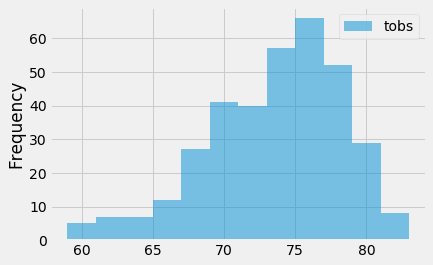

In [73]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC281_plotquery = engine.execute('SELECT date , tobs FROM measurement WHERE station = "USC00519281" AND date > "2016-08-23"').fetchall()
USC281_plotquery
#Create dataframe of frequency for plotting
usc281_df = pd.DataFrame(USC281_plotquery)
usc281_df = usc281_df.rename(columns={0: 'date', 1: 'tobs'})
#Histogram
usc281_df.plot.hist(bins = 12, alpha=.5)

![precipitation](Images/station-histogram.png)

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-04-08', '2017-04-15'))

[(67.0, 74.36734693877551, 82.0)]


([<matplotlib.axis.YTick at 0x28fbade7a90>,
 <a list of 6 Text yticklabel objects>)

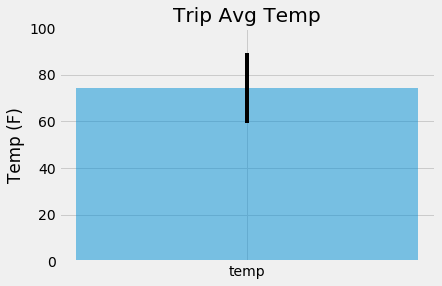

In [77]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_stats = calc_temps('2017-04-08', '2017-04-15')

trip_yaxis = trip_stats[0][1]
trip_min = trip_stats[0][0]
trip_max = trip_stats[0][2]
error = [trip_max - trip_min]

plt.bar("temp", trip_yaxis, alpha=.5, align = "center", yerr = error, width=.01)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0, 110, 20))

In [80]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcp_trip = engine.execute('SELECT measurement.station, name, latitude, longitude, elevation, AVG(prcp) FROM measurement \
LEFT JOIN station ON measurement.station = station.station \
WHERE date BETWEEN "2017-04-08" AND "2017-04-15" GROUP BY measurement.station ORDER BY AVG(prcp) DESC').fetchall()
prcp_trip

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.692857142857143),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.4275),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.185),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.148),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.03375),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


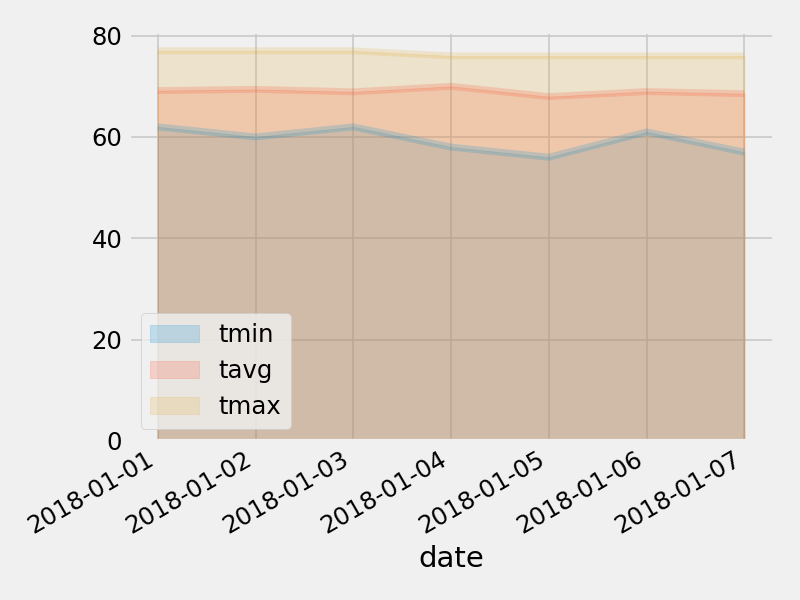

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
